In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/dataset/heart_failure_clinical_records

/content/drive/MyDrive/dataset/heart_failure_clinical_records


In [3]:
!ls

heart_failure_clinical_records_dataset.csv


# Importing and preprocessing data



In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

print('Rows:', len(df))
print('Columns:', len(df.columns))

Rows: 299
Columns: 13


In [5]:
na_values = df.isnull()
na_rows = na_values.any(axis=1)
print('Nan values in the dataset:', len(df[na_rows]), '\n')
df.dtypes

Nan values in the dataset: 0 



age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

# Exploratory data analysis

*   Numerical characteristics
*   Histograms
*   Box plots
*   Correlation matrix
*   Scatter plots



In [6]:
import statistics as stat

cols = [
        'age', 'creatinine_phosphokinase', 'ejection_fraction',
        'platelets', 'serum_creatinine', 'serum_sodium', 'time',
]

d = {
    'mean': stat.mean,
     'median': stat.median,
     'pop_stdev': stat.pstdev,
     'variance': lambda x: stat.pstdev(x)**2,
     '25th_percentile': lambda x: np.percentile(x, 25),
     '75th_percentile': lambda x: np.percentile(x, 75),
     'interquartile_range': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
     'min': min,
     'max': max,
}

df_num_stat = pd.DataFrame(None, d.keys())
for k in d.keys():
    f = d[k]
    for c in cols:
        df_num_stat.at[k, c] = round(f(df[c]), 3)

df_num_stat

age  creatinine_phosphokinase  ...  serum_sodium      time
mean                  60.834                   581.839  ...       136.625   130.261
median                60.000                   250.000  ...       137.000   115.000
pop_stdev             11.875                   968.664  ...         4.405    77.484
variance             141.013                938309.881  ...        19.405  6003.818
25th_percentile       51.000                   116.500  ...       134.000    73.000
75th_percentile       70.000                   582.000  ...       140.000   203.000
interquartile_range   19.000                   465.500  ...         6.000   130.000
min                   40.000                    23.000  ...       113.000     4.000
max                   95.000                  7861.000  ...       148.000   285.000

[9 rows x 7 columns]

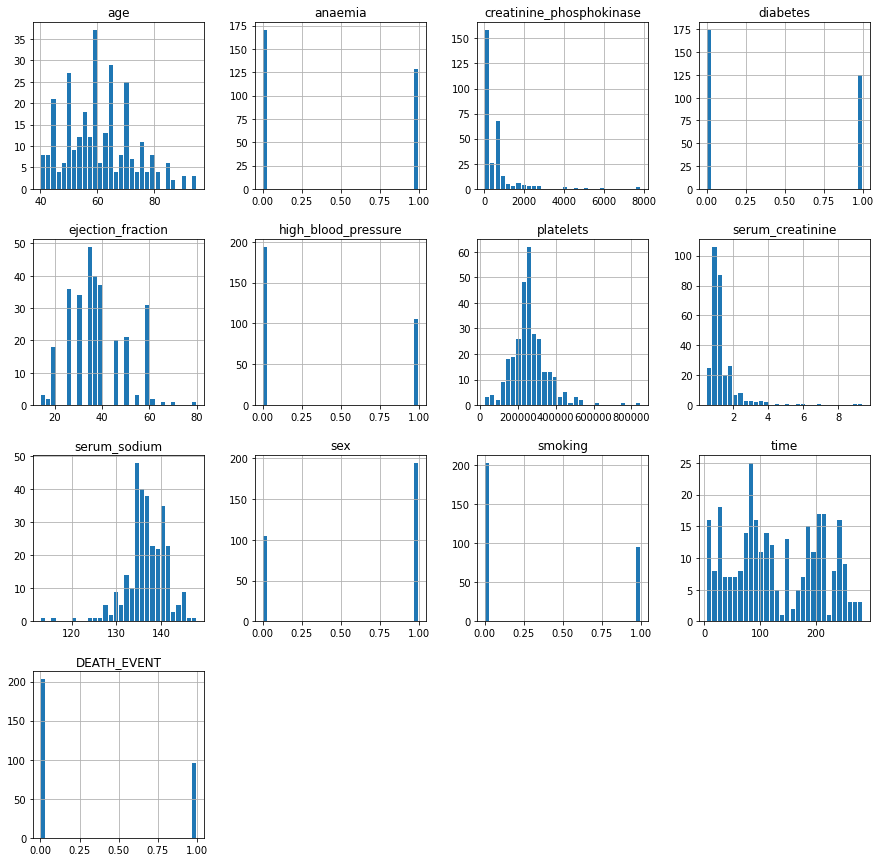

In [7]:
import matplotlib.pyplot as plt
import seaborn as sb

df.hist(bins=30, figsize=(15, 15), rwidth=0.8);

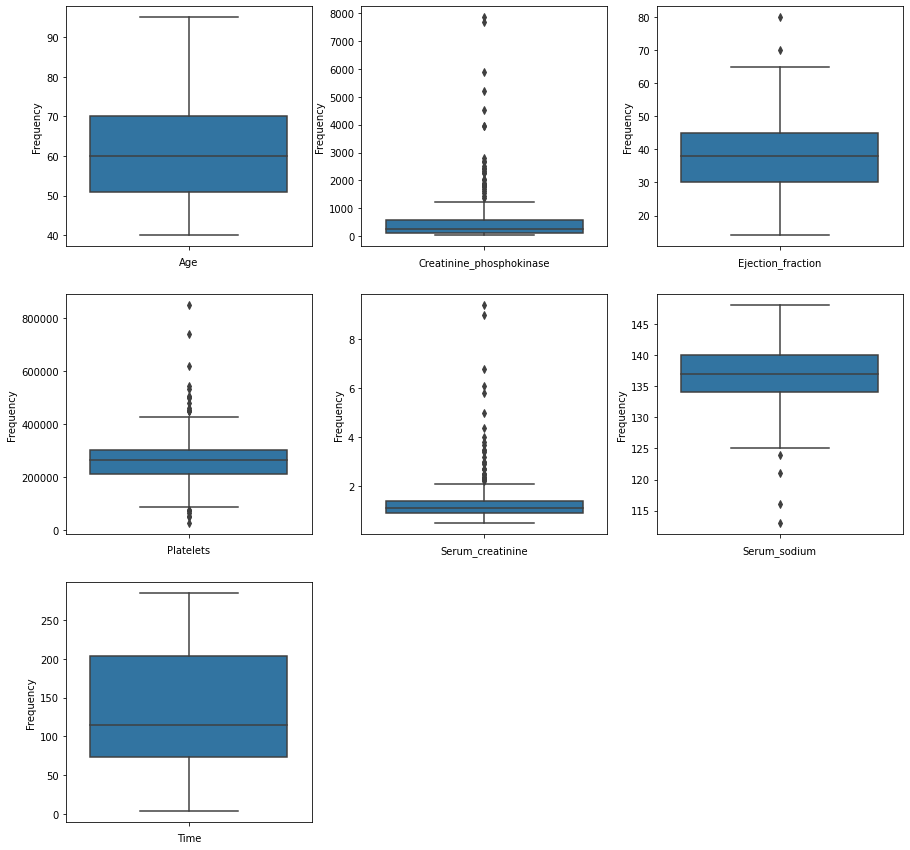

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
i_max, j_max = 3, 3

for i in range(i_max):
    for j in range(j_max):
        index = j + i * 3
        index = index if index < len(cols) else 0
        c = cols[index] 
        bp = sb.boxplot(y=df[c], ax=axs[i, j])
        axs[i, j].set_xlabel(c.capitalize())
        axs[i, j].set_ylabel('Frequency')

fig.delaxes(axs[2, 2])
fig.delaxes(axs[2, 1])
plt.show()

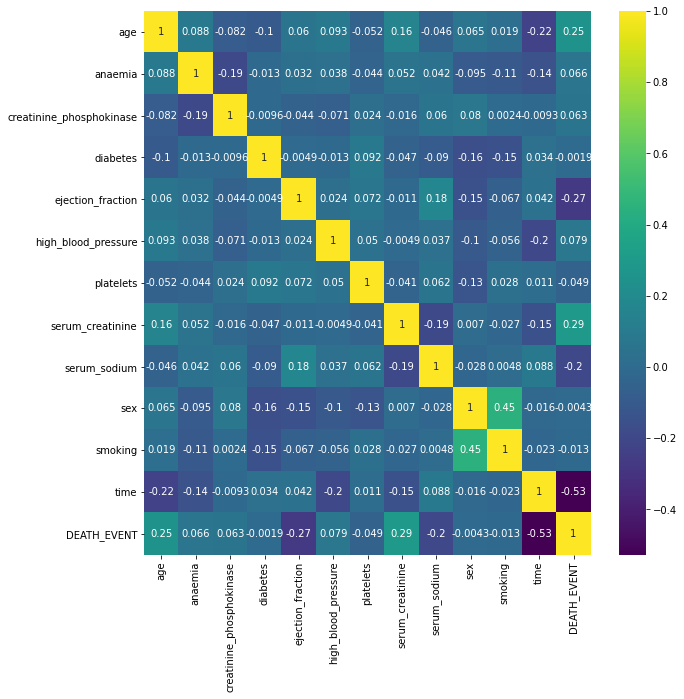

In [9]:
fig = plt.figure(figsize=(10, 10))

sb.heatmap(
    df.corr(),
    annot=True, 
    cmap='viridis'
);


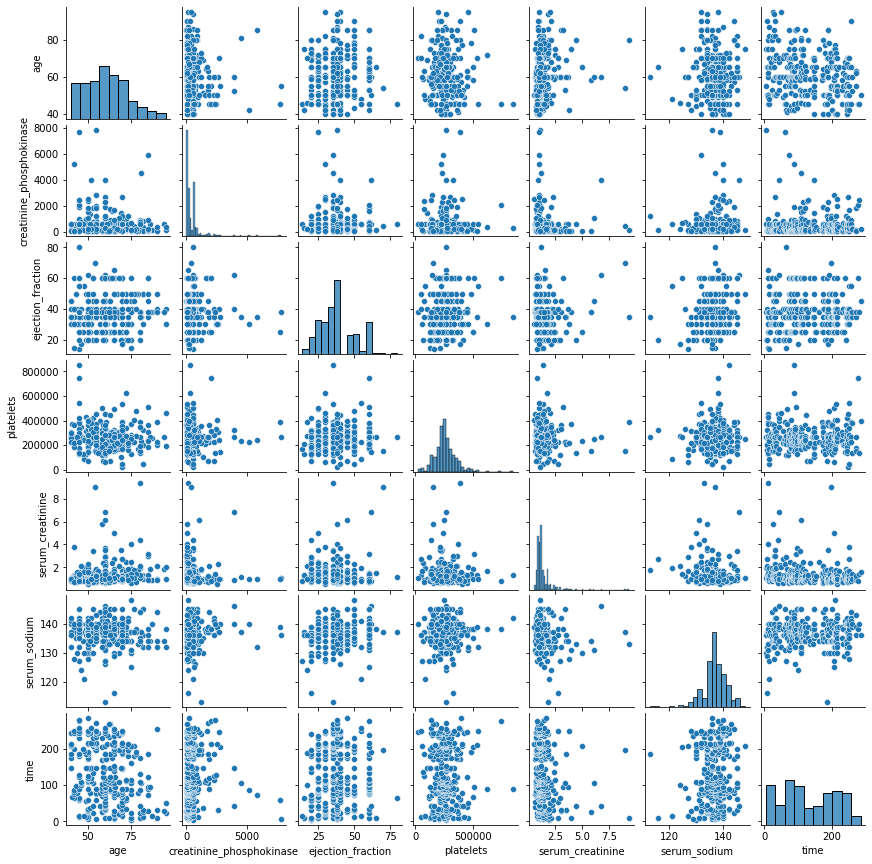

In [10]:
tmp = sb.pairplot(df[cols])
tmp.fig.set_size_inches(12, 12);

# Outlier detection

*   Isolation forest
*   Local outlier factor



In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler

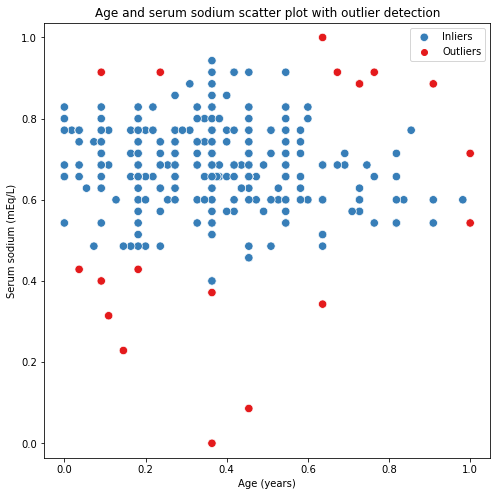

In [12]:
scaler_age_sodium = MinMaxScaler()
cols = ['age', 'serum_sodium']

fitted_age_sodium = pd.DataFrame(
    scaler_age_sodium.fit_transform(df[cols]),
    columns=cols,
)

isf = LocalOutlierFactor()
predictions_age_sodium = isf.fit_predict(fitted_age_sodium)

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum sodium scatter plot with outlier detection')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum sodium (mEq/L)')

sb.scatterplot(
    x=fitted_age_sodium[cols[0]],
    y=fitted_age_sodium[cols[1]],
    hue=predictions_age_sodium,
    palette='Set1',
    s=70,
)

plt.legend(['Inliers', 'Outliers']);

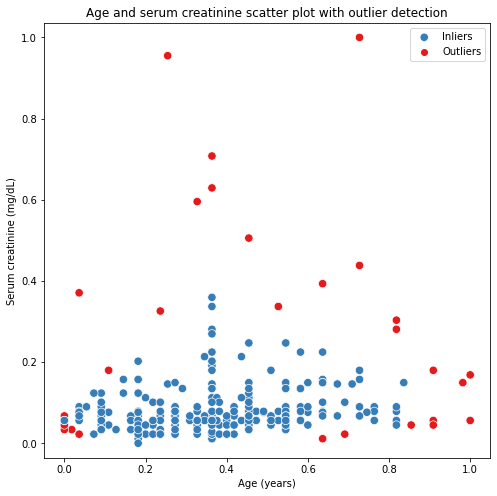

In [13]:
scaler_age_serum_creatinine = MinMaxScaler()
cols = ['age', 'serum_creatinine']

fitted_age_serum_creatinine = pd.DataFrame(
    scaler_age_serum_creatinine.fit_transform(df[cols]),
    columns=cols,
)

isf = IsolationForest(contamination=0.1)
predictions_age_serum_creatinine = isf.fit_predict(fitted_age_serum_creatinine)

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum creatinine scatter plot with outlier detection')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum creatinine (mg/dL)')

sb.scatterplot(
    x=fitted_age_serum_creatinine[cols[0]], 
    y=fitted_age_serum_creatinine[cols[1]],
    hue=predictions_age_serum_creatinine,
    palette='Set1',
    s=70,
)

plt.legend(['Inliers', 'Outliers']);

# Regression



*   Linear regression
*   Nearest neighbour regression
*   Regression using neural networks



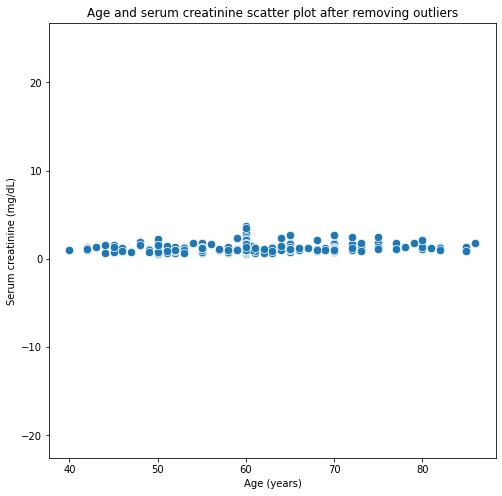

In [14]:
cols = ['age', 'serum_creatinine']
reg_df = fitted_age_serum_creatinine.iloc[np.where(predictions_age_serum_creatinine == 1)]

reg_df = pd.DataFrame(
    scaler_age_serum_creatinine.inverse_transform(reg_df),
    columns=cols,
)

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum creatinine scatter plot after removing outliers')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum creatinine (mg/dL)')

sb.scatterplot(
    x=reg_df[cols[0]],
    y=reg_df[cols[1]],
    palette='Set1',
    s=70,
);


Slope: 0.009
Intercept: 0.655

Mean squared error on train set: 0.197
Mean squared error on test set: 0.304


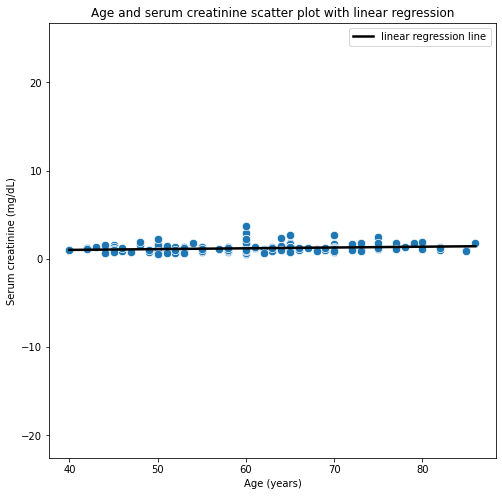

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

train, test = train_test_split(
    reg_df, 
    train_size=0.7, 
    test_size=0.3,
)

train, test = np.array(train), np.array(test)
x_train, x_test, y_train, y_test = train[:, 0], test[:, 0], train[:, 1], test[:, 1]

lr = LinearRegression(normalize=True)

lr.fit(
    np.reshape(x_train, (-1, 1)),
    np.reshape(y_train, (-1, 1)),
)

y_train_pred = lr.predict(np.reshape(x_train, (-1, 1)))
y_test_pred = lr.predict(np.reshape(x_test, (-1, 1)))

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum creatinine scatter plot with linear regression')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum creatinine (mg/dL)')

sb.scatterplot(
    x=x_train, 
    y=y_train, 
    palette='Set1', 
    s=70,
);

x = np.array([min(x_train), max(x_train)])

plt.plot(x,
    lr.predict(np.reshape(x, (-1, 1))),
    lw=2.5,
    c="k",
    label="linear regression line",
)

plt.legend()

print('Slope: {:.3f}'.format(lr.coef_[0, 0]))
print('Intercept: {:.3f}'.format(lr.intercept_[0]))
print('\nMean squared error on train set: {:.3f}'.format(mean_squared_error(y_train_pred, y_train)))
print('Mean squared error on test set: {:.3f}'.format(mean_squared_error(y_test_pred, y_test)))

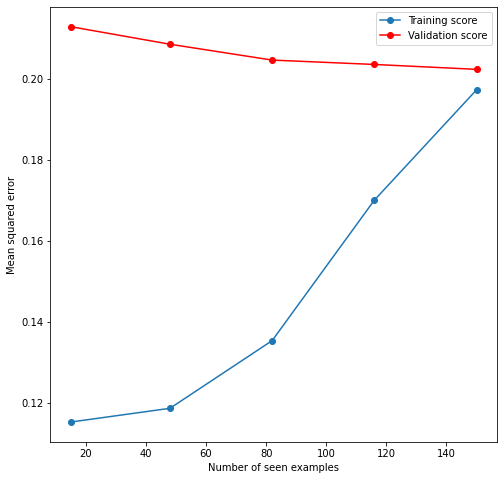

In [16]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    lr, 
    np.reshape(x_train, (-1,1)),
    np.reshape(y_train, (-1,1)),
    return_times=True,
    scoring='neg_mean_squared_error',
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 8))
plt.plot(
    train_sizes,
    -train_scores_mean,
    'o-',
    label="Training score",
)

plt.plot(
    train_sizes,
    -test_scores_mean, 
    'o-', 
    color='r',  
    label="Validation score",
)

plt.xlabel('Number of seen examples')
plt.ylabel('Mean squared error')
plt.legend();

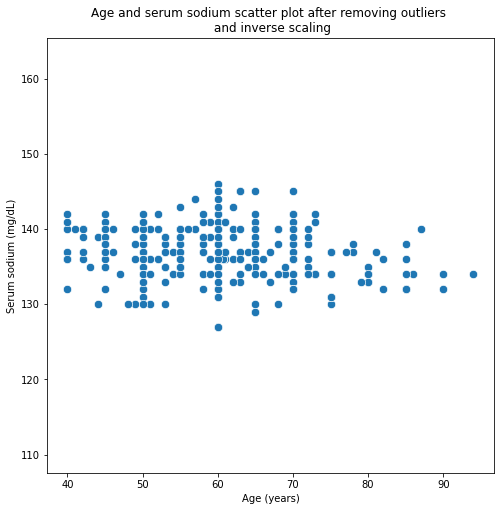

In [17]:
cols = ['age', 'serum_sodium']

reg_df = scaler_age_sodium.inverse_transform(fitted_age_sodium.iloc[np.where(predictions_age_sodium == 1)])
reg_df = pd.DataFrame(
    reg_df, 
    columns=cols
)

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum sodium scatter plot after removing outliers \n and inverse scaling')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum sodium (mg/dL)')

sb.scatterplot(
    x=reg_df[cols[0]],
    y=reg_df[cols[1]], 
    palette='Set1', 
    s=70,
);


Mean squared error on train set: 11.049
Mean squared error on test set: 14.173


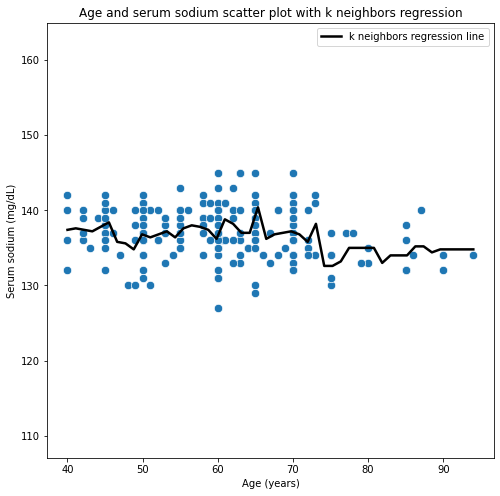

In [18]:
from sklearn.neighbors import KNeighborsRegressor

x_train, x_test, y_train, y_test = train_test_split(
    np.array(reg_df['age']),
    np.array(reg_df['serum_sodium']),
    train_size=0.7, 
    test_size=0.3,
)

knr = KNeighborsRegressor()
knr.fit(
    np.reshape(x_train, (-1, 1)),
    np.reshape(y_train, (-1, 1)),
)

y_train_pred = knr.predict(np.reshape(x_train, (-1, 1)))
y_test_pred = knr.predict(np.reshape(x_test, (-1, 1)))

fig = plt.figure(figsize=(8, 8)) 
plt.title('Age and serum sodium scatter plot with k neighbors regression')
plt.axis('equal')
plt.xlabel('Age (years)')
plt.ylabel('Serum sodium (mg/dL)')
sb.scatterplot(x=x_train, y=y_train, palette='Set1', s=70);

x = np.linspace(min(x_train), max(x_train))

plt.plot(
    x, 
    knr.predict(np.reshape(x, (-1, 1))), 
    lw=2.5, 
    c="k", 
    label='k neighbors regression line'
)

plt.legend()

print('\nMean squared error on train set: {:.3f}'.format(mean_squared_error(y_train_pred, y_train)))
print('Mean squared error on test set: {:.3f}'.format(mean_squared_error(y_test_pred, y_test)))

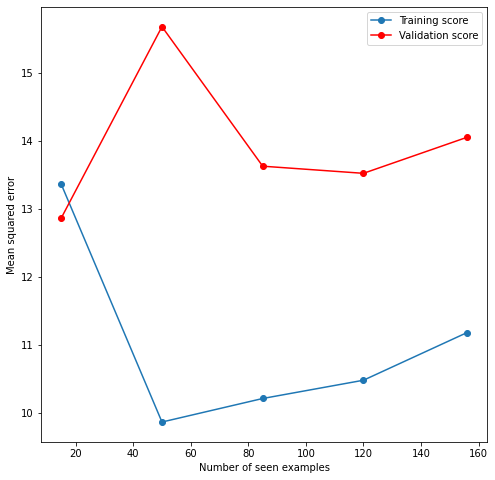

In [19]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    knr, 
    np.reshape(x_train, (-1,1)), 
    np.reshape(y_train, (-1,1)),
    return_times=True,
    scoring='neg_mean_squared_error',
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 8))
plt.plot(
    train_sizes, 
    -train_scores_mean, 
    'o-', 
    label="Training score"
)

plt.plot(
    train_sizes,
    -test_scores_mean,
    'o-', 
    color='r',  
    label="Validation score"
)

plt.xlabel('Number of seen examples')
plt.ylabel('Mean squared error')
plt.legend();

In [20]:
from tensorflow import keras
from keras.layers import Dense, BatchNormalization
from keras.models import Sequential

x = df.copy().drop('serum_sodium', axis=1)
y = df['serum_sodium']

model = Sequential()

model.add(BatchNormalization())
model.add(Dense(12, activation='relu', input_shape=(12, 1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    x=x, 
    y=y, 
    batch_size=64,
    epochs=60,
    validation_split=0.3,
    validation_batch_size=64,
)

Epoch 1/60
4/4 [==============================] - 25s 159ms/step - loss: 18607.0727 - val_loss: 16329.0029
Epoch 2/60
4/4 [==============================] - 0s 8ms/step - loss: 18492.6684 - val_loss: 14883.4775
Epoch 3/60
4/4 [==============================] - 0s 10ms/step - loss: 18149.4434 - val_loss: 13102.7803
Epoch 4/60
4/4 [==============================] - 0s 10ms/step - loss: 17704.4617 - val_loss: 10814.6602
Epoch 5/60
4/4 [==============================] - 0s 8ms/step - loss: 17088.4246 - val_loss: 8077.0786
Epoch 6/60
4/4 [==============================] - 0s 8ms/step - loss: 16093.7664 - val_loss: 5002.3984
Epoch 7/60
4/4 [==============================] - 0s 8ms/step - loss: 14536.8008 - val_loss: 2079.6372
Epoch 8/60
4/4 [==============================] - 0s 9ms/step - loss: 12437.6639 - val_loss: 544.7049
Epoch 9/60
4/4 [==============================] - 0s 9ms/step - loss: 9496.1113 - val_loss: 2875.8274
Epoch 10/60
4/4 [==============================] - 0s 9ms/step - l

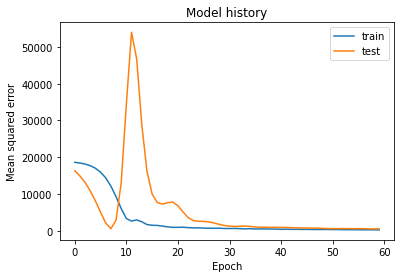

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model history')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#Classification 

*    Support vector classifier
*    Regression using neural networks
*    Nearest neighbor classifier
*    Decision tree classifier
*    Naive Bayes classifier
*    Logistic regression

In [22]:
def fit_using_grid_search(algorithm, param_dict):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, 
        train_size=0.7, 
        test_size=0.3
    )    
    grid_search = GridSearchCV(algorithm(), param_dict)
    grid_search.fit(x_train, y_train)
    return grid_search

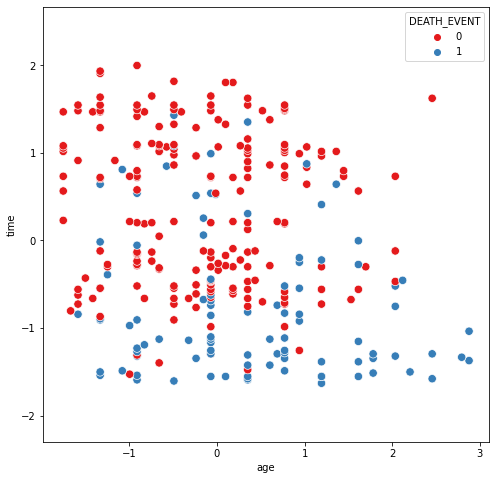

In [23]:
x_labs = ['age', 'time']
y_lab = 'DEATH_EVENT'

scaler = StandardScaler()

cl_df = pd.DataFrame(
    scaler.fit_transform(df[x_labs]),
    columns=x_labs,
)

cl_df[y_lab] = df[y_lab]

plt.figure(figsize=(8, 8))
plt.axis('equal')

sb.scatterplot(
    x=cl_df[x_labs[0]],
    y=cl_df[x_labs[1]], 
    hue=cl_df[y_lab], 
    palette='Set1', 
    s=70
);

In [39]:
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(
    cl_df[x_labs],
    cl_df[y_lab],
    train_size=0.7, 
    test_size=0.3
)

params = {
    'C': [0.05 + 0.05*i for i in range(1, 20)],
    'kernel': ['rbf','linear','poly', 'sigmoid'],
    'degree': [i for i in range(1, 10)]
}

grid_search = GridSearchCV(SVC(), params)
grid_search.fit(x_train.values, y_train.values)

print(grid_search.best_params_)
print(grid_search.score(x_test, y_test))

{'C': 0.35000000000000003, 'degree': 1, 'kernel': 'rbf'}
0.8111111111111111


In [40]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

def print_metrics(y_true, y_pred):
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('Confusion matrix: {}'.format(confusion_matrix(y_true, y_pred)))
    print('Precision score: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('Recall score: {:.3f}'.format(recall_score(y_true, y_pred)))
    print('F1 score: {:.3f}'.format(f1_score(y_true, y_pred)))

print('Train set metrics:\n')
print_metrics(
    y_train, 
    grid_search.predict(x_train.values),
)

print('\nTest set metrics:\n')
print_metrics(
    y_test, 
    grid_search.predict(x_test.values),
)

Train set metrics:

Accuracy: 0.842
Confusion matrix: [[142   6]
 [ 27  34]]
Precision score: 0.850
Recall score: 0.557
F1 score: 0.673

Test set metrics:

Accuracy: 0.811
Confusion matrix: [[54  1]
 [16 19]]
Precision score: 0.950
Recall score: 0.543
F1 score: 0.691


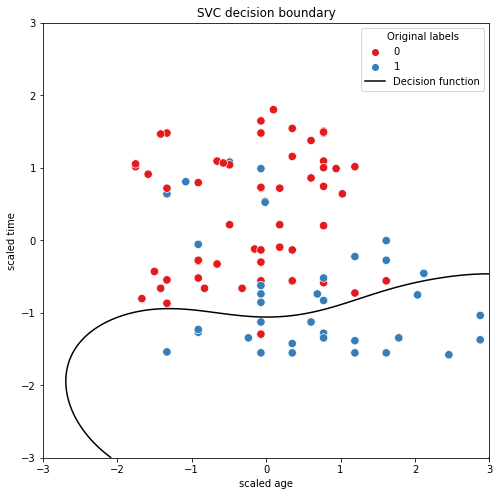

In [41]:
f, ax = plt.subplots(1, 1, figsize=(8,8))

x, y = np.meshgrid(
    np.linspace(-3, 3, 500), 
    np.linspace(-3, 3, 500),
)
z = grid_search.decision_function(np.c_[x.ravel(), y.ravel()])
z = z.reshape(x.shape)

plt.contour(
    x, y, z,
    levels=[0], 
    colors='black',
)

plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

sb.scatterplot(
    x=x_test.values[:, 0],
    y=x_test.values[:, 1],
    hue=y_test,
    palette='Set1',
    s=70,
)

handles, labels = plt.gca().get_legend_handles_labels()

line = plt.Line2D([0], [0],
    label='Decision function',
    color='black',
)
handles.extend([line])

plt.legend(
    handles=handles, 
    title='Original labels'
)

plt.xlabel('scaled age')
plt.ylabel('scaled time')
plt.title('SVC decision boundary');

In [27]:
from keras.optimizers import Adam
from keras.metrics import accuracy
from keras.callbacks import EarlyStopping

x = df.copy().drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

model = Sequential()

model.add(BatchNormalization())
model.add(Dense(12, activation='relu', input_shape=(12, 1)))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005), 
    metrics=['accuracy'],
)

history = model.fit(
    x=x,
    y=y,
    batch_size=64,
    epochs=100,
    validation_split=0.3,
    validation_batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=50)],
)

Epoch 1/100
4/4 [==============================] - 1s 96ms/step - loss: 0.6910 - accuracy: 0.5682 - val_loss: 0.3992 - val_accuracy: 0.9222
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6377 - accuracy: 0.7096 - val_loss: 0.4971 - val_accuracy: 0.9222
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.5963 - accuracy: 0.7513 - val_loss: 0.6000 - val_accuracy: 0.9222
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5718 - accuracy: 0.7105 - val_loss: 0.7077 - val_accuracy: 0.9222
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.5467 - accuracy: 0.7750 - val_loss: 0.6967 - val_accuracy: 0.9222
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.5291 - accuracy: 0.7658 - val_loss: 0.6162 - val_accuracy: 0.9222
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5052 - accuracy: 0.7727 - val_loss: 0.5639 - val_accuracy: 0.9222
Epoch 8/100
4/4 [=======

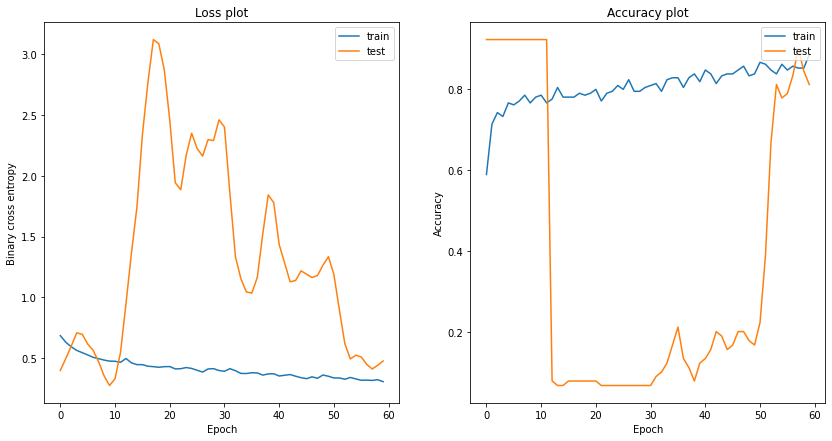

In [28]:
_, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss plot')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary cross entropy')
axs[0].legend(
    ['train', 'test'],
    loc='upper right'
)

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy plot')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(
    ['train', 'test'], 
    loc='upper right'
);

8 components:  0.9601268620226923


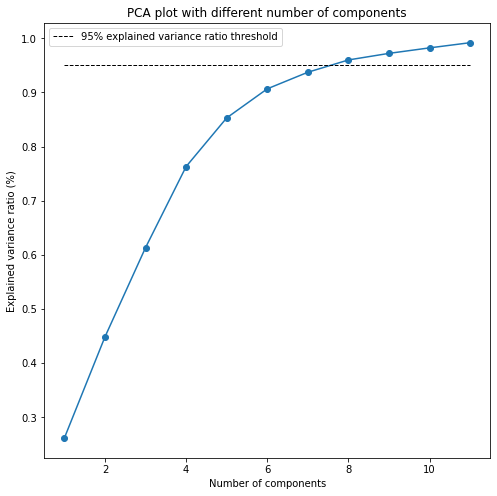

In [29]:
from sklearn.decomposition import PCA

y = df['DEATH_EVENT']
x = df.copy().drop('DEATH_EVENT', axis=1)

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

d = {}
for i in range(1, 12):
    pca = PCA(n_components=i).fit(x)
    d[i] = np.sum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,8))
plt.plot(
    list(d.keys()), 
    list(d.values()), 
    'o-'
)

plt.title('PCA plot with different number of components')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio (%)')

plt.plot(
    [1, 11], [0.95, 0.95],
    '--', 
    lw=1, 
    color='black', 
    label='95% explained variance ratio threshold'
)

plt.legend();

print('8 components: ',d[8])

In [30]:
pca = PCA(n_components=8)
x = pca.fit_transform(x)

{'n_neighbors': 19}


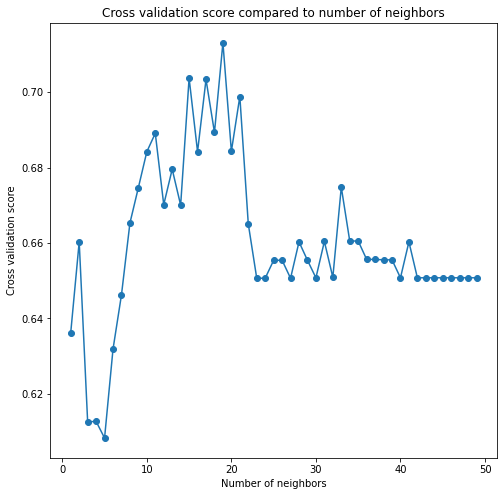

In [31]:
from sklearn.neighbors import KNeighborsClassifier

grid_search = fit_using_grid_search(
    KNeighborsClassifier, 
    {'n_neighbors':list(range(1,50))}
)

plt.figure(figsize=(8, 8))
plt.plot(
    grid_search.cv_results_['param_n_neighbors'], 
    grid_search.cv_results_['mean_test_score'], 
    'o-'
)

plt.xlabel('Number of neighbors')
plt.ylabel('Cross validation score')
plt.title('Cross validation score compared to number of neighbors');

print(grid_search.best_params_)

In [32]:
knc = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knc.fit(x_train, y_train)

print('Train set metrics:\n')
print_metrics(
    y_train, 
    knc.predict(x_train)
)

print('\nTest set metrics:\n')
print_metrics(
    y_test, 
    knc.predict(x_test)
)

Train set metrics:

Accuracy: 0.799
Confusion matrix: [[125  11]
 [ 31  42]]
Precision score: 0.792
Recall score: 0.575
F1 score: 0.667

Test set metrics:

Accuracy: 0.856
Confusion matrix: [[65  2]
 [11 12]]
Precision score: 0.857
Recall score: 0.522
F1 score: 0.649


{'max_depth': 4}


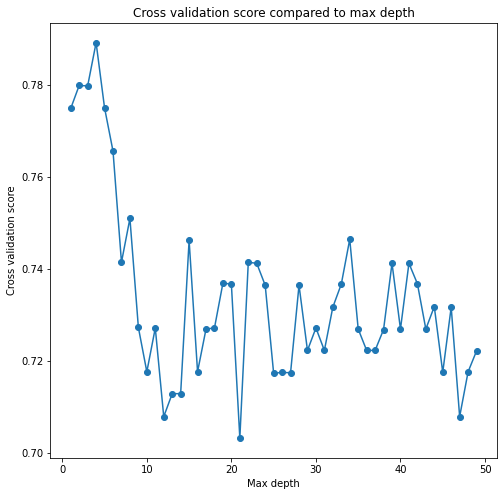

In [33]:
from sklearn.tree import DecisionTreeClassifier

grid_search = fit_using_grid_search(
    DecisionTreeClassifier, 
    {'max_depth':list(range(1,50))}
)

plt.figure(figsize=(8, 8))
plt.plot(grid_search.cv_results_['param_max_depth'], grid_search.cv_results_['mean_test_score'], 'o-')
plt.xlabel('Max depth')
plt.ylabel('Cross validation score')
plt.title('Cross validation score compared to max depth');

print(grid_search.best_params_)

In [34]:
dtc = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'])
dtc.fit(x_train, y_train)

print('Train set metrics:\n')
print_metrics(y_train, dtc.predict(x_train))

print('\nTest set metrics:\n')
print_metrics(y_test, dtc.predict(x_test))

Train set metrics:

Accuracy: 0.856
Confusion matrix: [[123  13]
 [ 17  56]]
Precision score: 0.812
Recall score: 0.767
F1 score: 0.789

Test set metrics:

Accuracy: 0.856
Confusion matrix: [[58  9]
 [ 4 19]]
Precision score: 0.679
Recall score: 0.826
F1 score: 0.745


{'alpha': 13}


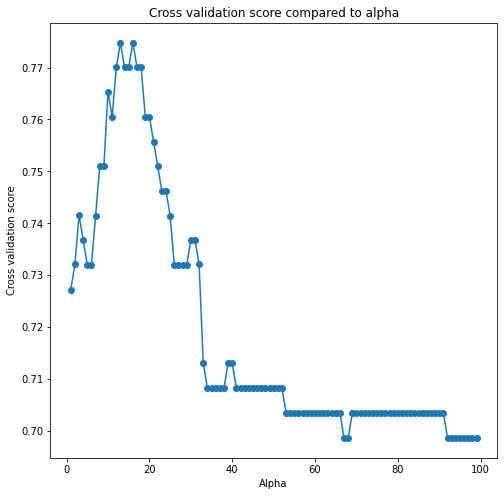

In [35]:
from sklearn.naive_bayes import BernoulliNB

grid_search = fit_using_grid_search(
    BernoulliNB, 
    {'alpha': [i for i in range(1, 100)]}
)

plt.figure(figsize=(8, 8))
plt.plot(
    grid_search.cv_results_['param_alpha'], 
    grid_search.cv_results_['mean_test_score'], 
    'o-'
)

plt.xlabel('Alpha')
plt.ylabel('Cross validation score')
plt.title('Cross validation score compared to alpha');

print(grid_search.best_params_)

In [36]:
nb = BernoulliNB(alpha=grid_search.best_params_['alpha'])
nb.fit(x_train, y_train)

print('Train set metrics:\n')
print_metrics(
    y_train, 
    nb.predict(x_train)
)

print('\nTest set metrics:\n')
print_metrics(
    y_test, 
    nb.predict(x_test)
)

Train set metrics:

Accuracy: 0.694
Confusion matrix: [[109  27]
 [ 37  36]]
Precision score: 0.571
Recall score: 0.493
F1 score: 0.529

Test set metrics:

Accuracy: 0.767
Confusion matrix: [[59  8]
 [13 10]]
Precision score: 0.556
Recall score: 0.435
F1 score: 0.488


{'C': 1.0}


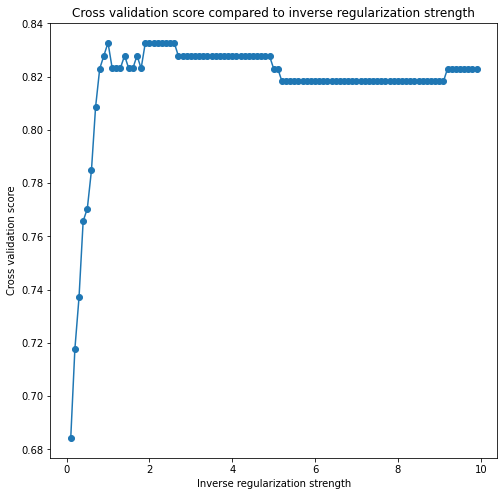

In [37]:
from sklearn.linear_model import LogisticRegression

grid_search = fit_using_grid_search(
    LogisticRegression, 
    {'C': [0.1*i for i in range(1, 100)]}
)

plt.figure(figsize=(8, 8))
plt.plot(
    grid_search.cv_results_['param_C'], 
    grid_search.cv_results_['mean_test_score'], 
    'o-'
)

plt.xlabel('Inverse regularization strength')
plt.ylabel('Cross validation score')
plt.title('Cross validation score compared to inverse regularization strength');

print(grid_search.best_params_)

In [38]:
nb = LogisticRegression(C=grid_search.best_params_['C'])
nb.fit(x_train, y_train)

print('Train set metrics:\n')
print_metrics(
    y_train, 
    nb.predict(x_train)
)

print('\nTest set metrics:\n')
print_metrics(
    y_test, 
    nb.predict(x_test)
)

Train set metrics:

Accuracy: 0.794
Confusion matrix: [[119  17]
 [ 26  47]]
Precision score: 0.734
Recall score: 0.644
F1 score: 0.686

Test set metrics:

Accuracy: 0.867
Confusion matrix: [[63  4]
 [ 8 15]]
Precision score: 0.789
Recall score: 0.652
F1 score: 0.714
